# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.585903,True,7.002140
1,-0.821266,True,2.463156
2,-0.786433,True,3.241726
3,-1.554161,False,-1.955654
4,-0.886792,False,-0.141751
...,...,...,...
995,0.409150,True,6.839635
996,1.207553,True,8.023573
997,-1.835247,False,-1.270066
998,0.679177,True,5.800222


<AxesSubplot: xlabel='v0'>

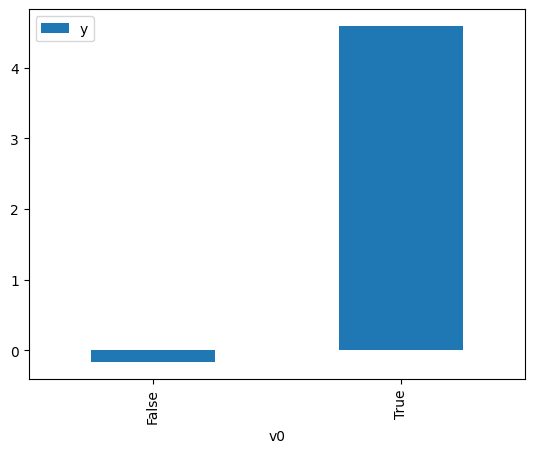

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

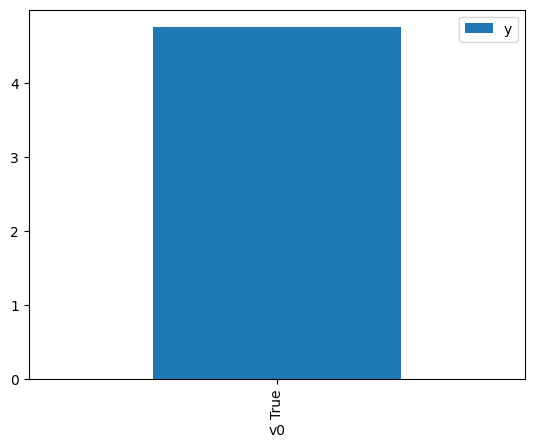

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.313676,False,0.489433,0.415752,2.405280
1,-0.217045,False,-0.011575,0.584972,1.709482
2,0.607472,False,-0.251902,0.327705,3.051523
3,-0.749174,False,-1.220456,0.736623,1.357547
4,0.598261,False,0.827094,0.330324,3.027334
...,...,...,...,...,...
995,0.099360,False,0.747844,0.483945,2.066352
996,0.325307,False,0.516740,0.412118,2.426487
997,-0.217045,False,-0.011575,0.584972,1.709482
998,-0.224815,False,0.807746,0.587399,1.702419


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.652662,True,3.134866,0.029893,33.452447
1,0.747024,True,5.713397,0.710599,1.407263
2,-0.867839,True,3.653335,0.234818,4.258619
3,1.388894,True,4.695096,0.848757,1.178193
4,-0.219871,True,4.545597,0.414144,2.414617
...,...,...,...,...,...
995,-0.768196,True,3.362177,0.258652,3.866191
996,0.786778,True,4.833393,0.721013,1.386938
997,0.973696,True,6.389377,0.766777,1.304160
998,-0.375792,True,2.859198,0.366409,2.729187


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7350.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):                        0.00
Time:                        20:46:15   Log-Likelihood:                         -1423.6
No. Observations:                1000   AIC:                                      2851.
Df Residuals:                     998   BIC:                                      2861.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3252      0.032     41.374      0.000       1.262       1.388
x2             4.9061      0.049    100.143      0.000       4.810       5.002
==============================================================================
Omnibus:                        0.104   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.062
Skew:                          -0.017   Prob(JB):                        0.969
Kurtosis:                       3.019   Cond. No.                         1.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""